In [83]:
# Initial imports
import os
import pandas as pd
import numpy as np
import requests
import datetime
from datetime import datetime, timedelta, date
from dateutil.parser import parse
import matplotlib.pyplot as plt

#Alpaca API imports
import alpaca_trade_api as tradeapi

#Twitter API imports
import tweepy as tw

# NLP & Sentiment imports
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Import required Keras modules
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Download/Update the VADER Lexicon
nltk.download('vader_lexicon')

from dotenv import load_dotenv
load_dotenv()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Kris/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [84]:
############################################################
"""
    Authenticates the APIs for Alpaca and Twitter
    Returns a pass/fail statement
"""
############################################################  

def api_auth():
    
    # Setting twitter access and api keys
    bearer_token = os.getenv("TWITTER_BEARER_TOKEN")
    consumer_key= os.getenv("TWITTER_API_KEY")
    consumer_secret= os.getenv("TWITTER_SECRET_KEY")
    access_token= os.getenv("TWITTER_ACCESS_TOKEN")
    access_token_secret= os.getenv("TWITTER_ACCESS_TOKEN_SECRET")

    # Set Alpaca API key and secret
    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

    alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

    # authentication for twitter
    auth = tw.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    twitter_api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    # test authentication
    try:
        twitter_api.verify_credentials()
        auth = "Twitter Authentication Verified"
    except:
        auth = "Error During Twitter Authentication"
    
    return print(auth)


############################################################
"""
    Cleans the tweets and removes the included url
    
    Note: Did not use this function in the end, as VADER
    does better with punctuation, emojis, and CAPS.
"""
############################################################

def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())



############################################################
"""
    Sentiment calculation based on compound score
"""
############################################################

def get_normalized(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.04:  # Positive
        result = 1
    elif score <= -0.04:  # Negative
        result = -1

    return result


############################################################
"""
    Function that pulls stock data from a given ticker and timeframe.
"""
############################################################

def daily_returns(ticker, timeframe):
        
    # Set current date and the date from one month ago using the ISO format
    current_date = pd.Timestamp.now(tz="America/New_York").isoformat()
    past_date = pd.Timestamp("2020-12-01 00:00", tz="America/New_York").isoformat()

    # Get 4 weeks worth of historical data for AAPL
    df = alpaca_api.get_barset(
        ticker,
        timeframe,
        limit=None,
        start=past_date,
        end=current_date,
        after=None,
        until=None,
    ).df
        
    return df



############################################################
"""
    Twitter: Scrape Tweets and Analyze Sentiment
"""
############################################################

def twitter_sentiment(search_words, date_since, items):
    
    # Initialize the VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()

    # initializing the tweets dataframe
    df = []
    
    # adding retweet filter to search words
    search_words = search_words + " -filter:retweets"
    
    # Fetch top tweets/hastags for given ticker
    tweets = tw.Cursor(twitter_api.search,
              q=search_words,
              lang="en",
              since=date_since
                    ).items(items)
    
    for tweet in tweets:
    
        tweet_fetched = tweet.text 
        #Clean text of tweets
        #remove_url(tweet.text)

        # Get date of tweet
        tweet_date = pd.Timestamp(tweet.created_at, tz="America/New_York").isoformat()
        
        try:
            sentiment = analyzer.polarity_scores(tweet_fetched)
            compound = sentiment["compound"]
            #pos = sentiment["pos"]
            #neu = sentiment["neu"]
            #neg = sentiment["neg"]
        
            df.append({
                "date": tweet_date,
                "tweet": tweet_fetched,
                "compound": compound,
                #"positive": pos,
                #"negative": neg,
                #"neutral": neu
            
            })
        
        except AttributeError:
            pass
    
    df = pd.DataFrame(df)
    
    return df



############################################################
"""
    get_twitter_sentiment(search_words):
    Takes 1 argument, word(s) to search tweets for.
    
    Scrapes Twitter for given search words in tweet
    Calculates compound sentiment with VADER sentiment analyzer on each tweet
    Calculates average compound sentiment score each 1 hour
    Normalizes average hourly VADER compound score
    Returns Average Hourly Sentiment Dataframe with Columns: 
"""
############################################################

def get_twitter_sentiment(search_words):

    # tweepy variables
    search_words = search_words
    date_since = "2020-10-01"
    items = 10000

    # call the twitter sentiment function and return a dataframe
    tweets_df = twitter_sentiment(search_words, date_since, items)

    # Changes the date column to proper datetime format
    tweets_df['date'] = pd.to_datetime(tweets_df['date'])
    # Code below didn't produce proper result downstream - saving for reference
    # Creates datetime object and outputs only the Date and Hour for each tweet
    # tweets_df['date'] = tweets_df['date'].apply(lambda x: pd.Timestamp(x).strftime('%m-%d-%Y %H'))

    # Save raw tweets dataframe to csv
    # Next steps, 
        # 1. Scan folder to see if csv file of user input ticker exists
        # 2. Create the new filename as a user input variable if csv does not exist
        # 3. If csv file already exists, open, append new date rows, save, close.
    # tweets_df.to_csv(r'C:\Users\Kris\Documents\ucb_fintech\Homework\Project2\tweets\msft_tweets.csv')
    
    # Grouping the tweets by Hour and taking their average Hourly sentiment
    avg_hourly_sentiment = tweets_df.groupby(pd.Grouper(key='date', freq='H')).mean().dropna()
    
    # Get the normalized sentiment score of -1, 0, 1
    avg_hourly_sentiment["normalized"] = avg_hourly_sentiment["compound"].apply(lambda x : get_normalized(x))
    
    return avg_hourly_sentiment


############################################################
"""
    get_ticker_data(ticker):
    Takes 1 argument, ticker to search tweets for.
    
    Scrapes Twitter for given search words.
    Calculates compound sentiment with VADER sentiment analyzer 
    Normalizes VADER compound score
    Returns Average Daily Sentiment Dataframe with Columns: 
"""
############################################################

def get_ticker_data(ticker):

    # alpaca api variables
    ticker = ticker
    timeframe = "15Min"

    # call the alpaca api and return a dataframe of daily returns
    daily_df = daily_returns(ticker, timeframe)

    # Drop Outer Table Level and drop extra columns
    daily_df = daily_df.droplevel(axis=1, level=0)
    daily_df = daily_df.drop(columns=["open", "high", "low", "volume"])

    # Get the percent change of the closing prices, drop any NA rows, and reset the index
    returns_df = daily_df.pct_change().dropna()
    returns_df.reset_index(inplace = True)

    # Grouping the tweets by Hour and taking their average Hourly sentiment
    avg_hourly_returns = returns_df.groupby(pd.Grouper(key='time', freq='H')).mean().dropna()

    return avg_hourly_returns



############################################################
"""
    combine_sentiment_with_close(avg_hourly_returns, avg_hourly_sentiment):
    Takes 2 arguments: the two dataframes to combine
"""
############################################################

def combine_sentiment_with_close(avg_hourly_sentiment, avg_hourly_returns):

    # Combines the average hourly Twitter sentiment dataframe with the hourly percent change dataframe
    combined_df = avg_hourly_returns.join(avg_hourly_sentiment).dropna(how="any")
    
    return combined_df



############################################################
"""
    main_function:
    Defines the main function.
    1 argument: search word to search twitter and stock prices.
"""
############################################################

def main_function(twitter_search_word, ticker):
    
    api_auth()
    twitter_sentiment = get_twitter_sentiment(twitter_search_word)
    percent_change = get_ticker_data(ticker)
    combined_df = combine_sentiment_with_close(twitter_sentiment, percent_change)
    
    return combined_df

In [85]:
twitter_search_word = "microsoft" + " MSFT"
ticker = "MSFT"

combined_df = main_function(twitter_search_word, ticker)
combined_df

Authentication OK


,close,compound,normalized
time,,,
2021-01-11 13:00:00+00:00,-0.004513,0.404767,1.0
2021-01-11 14:00:00+00:00,-0.000283,0.185950,1.0
2021-01-11 15:00:00+00:00,0.001134,0.564075,1.0
2021-01-11 16:00:00+00:00,-0.000466,0.152675,1.0
2021-01-11 17:00:00+00:00,0.000327,0.310820,1.0
2021-01-11 18:00:00+00:00,-0.000544,0.223414,1.0
2021-01-11 19:00:00+00:00,0.000150,0.156942,1.0
2021-01-11 20:00:00+00:00,-0.000355,0.189300,1.0
2021-01-12 13:00:00+00:00,-0.001079,0.135783,1.0


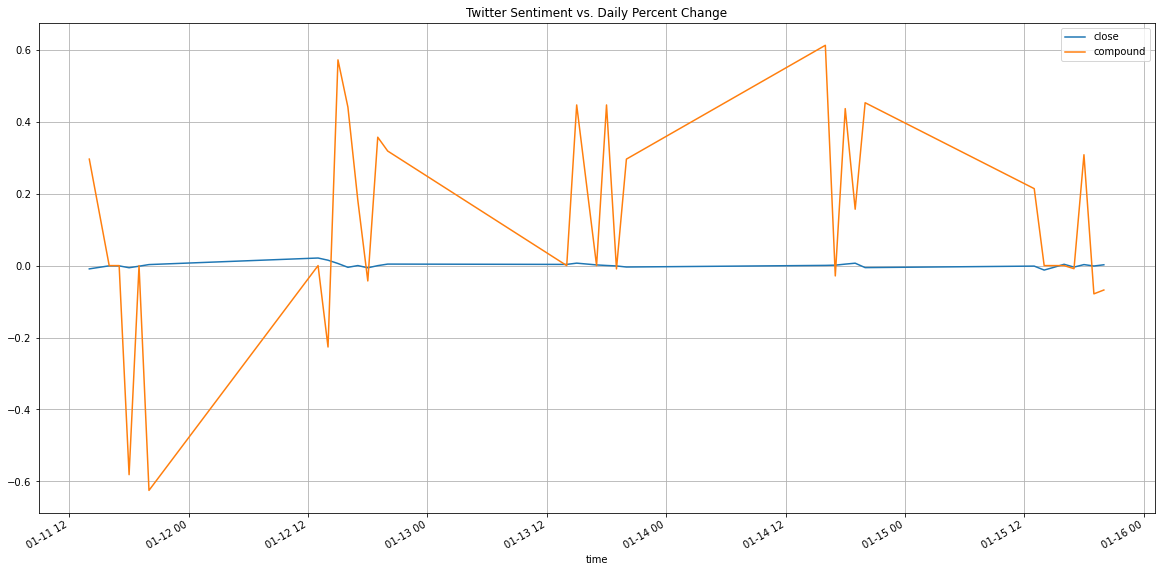

In [76]:
combined_df.plot(
    y=["close","compound"],
    kind="line",
    title= "Twitter Sentiment vs. Daily Percent Change",
    figsize= (20,10),
    grid=True,
);

In [77]:
# Get descriptive stats from the DataFrame
combined_df.describe()

,close,compound,normalized
count,33.000000,33.000000,33.000000
mean,0.000569,0.117143,0.272727
std,0.006358,0.286821,0.761279
min,-0.012442,-0.624900,-1.000000
25%,-0.003970,-0.008600,0.000000
50%,0.000081,0.000000,0.000000
75%,0.003286,0.318450,1.000000
max,0.021053,0.612400,1.000000


In [78]:
# Correlate the twitter sentiment to returns
combined_df.corr().style.background_gradient()

,close,compound,normalized
close,1.000000,-0.011789,-0.036893
compound,-0.011789,1.000000,0.873157
normalized,-0.036893,0.873157,1.000000


In [86]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    
    `df`: The original DataFrame with the time series data.
    `window`: The window size in days of previous closing prices that will be used for the prediction.
    `feature_col_number`: The column number from the original DataFrame where the features are located.
    `target_col_number`: The column number from the original DataFrame where the target is located.
  
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [87]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 5

feature_column = 1
target_column = 0

X, y = window_data(combined_df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[0.40476667 0.18595    0.564075   0.152675   0.31082   ]
 [0.18595    0.564075   0.152675   0.31082    0.22341429]
 [0.564075   0.152675   0.31082    0.22341429 0.15694231]
 [0.152675   0.31082    0.22341429 0.15694231 0.1893    ]
 [0.31082    0.22341429 0.15694231 0.1893     0.13578333]] 

y sample values:
[[-0.00054401]
 [ 0.00015002]
 [-0.0003548 ]
 [-0.00107946]
 [-0.00495028]]


In [88]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [89]:
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [90]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.68676318]
  [0.25651928]
  [1.        ]
  [0.20313874]
  [0.53368924]]

 [[0.25651928]
  [1.        ]
  [0.19109298]
  [0.53368924]
  [0.35099613]]

 [[1.        ]
  [0.19109298]
  [0.50204242]
  [0.35099613]
  [0.21205816]]

 [[0.19109298]
  [0.50204242]
  [0.33018268]
  [0.21205816]
  [0.27969135]]

 [[0.50204242]
  [0.33018268]
  [0.19948349]
  [0.27969135]
  [0.16783223]]] 

X_test sample values:
[[[0.80424951]
  [0.54080337]
  [0.71286722]
  [0.54631621]
  [0.38360085]]

 [[0.54080337]
  [0.71286722]
  [0.51392064]
  [0.38360085]
  [0.52274868]]

 [[0.71286722]
  [0.51392064]
  [0.360854  ]
  [0.52274868]
  [0.54572566]]

 [[0.51392064]
  [0.360854  ]
  [0.49175061]
  [0.54572566]
  [0.80272743]]

 [[0.360854  ]
  [0.49175061]
  [0.5133651 ]
  [0.80272743]
  [0.1293382 ]]]


In [91]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Summarize the model
model.summary()

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test)

In [ ]:
# Make some predictions
predicted = model.predict(X_test)

In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()

In [ ]:
# Plot the real vs predicted prices as a line chart
stocks.plot()